# Proof of Concept for loading and plotting data

In [23]:
import matplotlib.pyplot as plt; plt.style.use('seaborn-v0_8')
import numpy as np
from dql.utils.datamanager import ConcatDataManager, DataManager
from scipy.signal import savgol_filter

In [24]:
def smooth(arr: np.ndarray, minV: int = None, maxV: int = None, window: int = None) -> np.ndarray:
    if window is None:
        window = arr.shape[0] // 10 + 1
    smoothed = savgol_filter(arr, window, 3)
    if minV is not None or maxV is not None:
        return np.clip(smoothed, minV, maxV)
    return smoothed

In [25]:
CDM = ConcatDataManager('BF-BL')
summary = CDM.loadSummary()
for k1, v1 in summary.items():
    print(f'{k1}:')
    for k2, v2 in v1.items():
        if type(v2) is dict:
            print(f'\t{k2}:')
            for k3, v3 in v2.items():
                print(f'\t\t{k3}: {v3}')
        else:
            if type(v2) is float:
                print(f'\t{k2}: {v2:.4f}')
            else:
                print(f'\t{k2}: {v2}')

meta:
	runID: BF-BL
	numRepetitions: 5
	numEpisodes: 50000
	runs: 5
params:
	explorationStrategy: egreedy
	annealingScheme:
		id: 1
		startVal: 1.0
		endVal: 0.01
		window: 0.8
		kind: exponential
	experienceReplay: False
	targetNetwork: False
	replayBufferSize: None
	targetFrequency: None
	alpha: 0.0010
	gamma: 0.9990
	batchSize: 512
results:
	avgRuntime: 01:08:08.948 hr
	avgReward: 48.5306
	avgActionBias: 0.5204
	avgLoss: 38.2536


In [26]:
rewards = CDM.loadRewards()
avgRewards = np.mean(rewards, axis=0)

actions = CDM.loadActions()
normAction0 =  (actions / np.sum(actions, axis=2, keepdims=True))[:, :, 0]
actionBiases = np.abs(normAction0 - .5) * 2
avgActionBiases = np.mean(actionBiases, axis=0)

losses = CDM.loadLosses()
avgLosses = np.nanmean(losses, axis=0)

numReps = summary.meta.numRepetitions


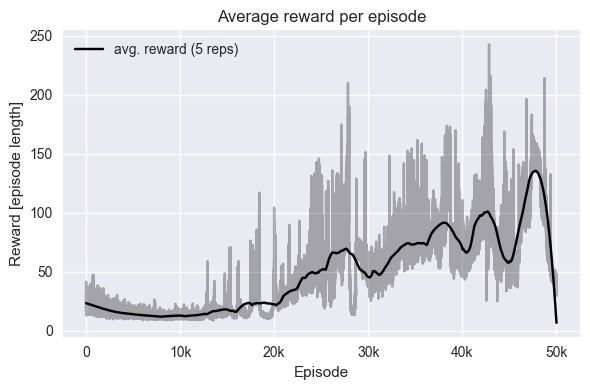

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(avgRewards, color='k', alpha=0.3)
ax.plot(smooth(avgRewards, minV=0, maxV=500), color='k', label=f'avg. reward ({numReps} reps)')
ax.set_xlabel('Episode')
ax.xaxis.set_major_formatter(lambda x, _: f'{x / 1000:.0f}k' if x >= 1000 else f'{x:.0f}')
ax.set_ylabel('Reward [episode length]')
ax.set_title('Average reward per episode')
ax.legend()

fig.tight_layout();

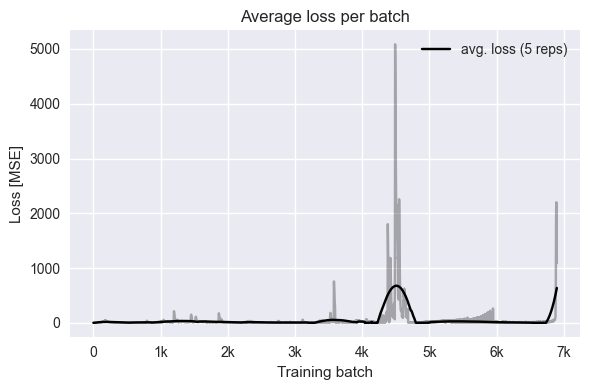

In [28]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(avgLosses, color='k', alpha=0.3)
ax.plot(smooth(avgLosses, minV=0), color='k', label=f'avg. loss ({numReps} reps)')
ax.set_xlabel('Training batch')
ax.xaxis.set_major_formatter(lambda x, _: f'{x / 1000:.0f}k' if x >= 1000 else f'{x:.0f}')
ax.set_ylabel('Loss [MSE]')
ax.set_title('Average loss per batch')
ax.legend()
fig.tight_layout();

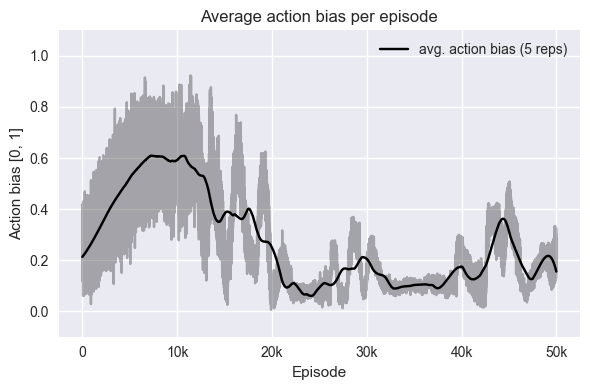

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(avgActionBiases, color='k', alpha=0.3)
ax.plot(smooth(avgActionBiases, minV=0, maxV=1), color='k', label=f'avg. action bias ({numReps} reps)')
ax.set_xlabel('Episode')
ax.xaxis.set_major_formatter(lambda x, _: f'{x / 1000:.0f}k' if x >= 1000 else f'{x:.0f}')
ax.set_ylabel('Action bias [0, 1]')
ax.set_ylim(-.1, 1.1)
ax.set_title('Average action bias per episode')
ax.legend()
fig.tight_layout();